# NLP

Recall in section 2.2 Data Visualisuation, we found that California faced the greatest threat to water supply from 2017 to 2021. Therefore, we might be further interested in studying the risk descriptions of the water supply risk for California, compared to the rest of the US (**NB**: this was not included in our predefined research questions). Specifically, we'd like to know how California is different than the other states, since it was highlighted as having the greatest threat across 2017, 2018 and 2021. 

## Data Fetching 

To study how California is different from the other states, we will use the **us.csv** file and explore the risk descriptions per states across years. Let's load the data in.

In [1]:
# Loading packages 
import pandas as pd #for loading 
import nltk         #for natural language processing 
import gensim       #for removing punctuation, tokenisation and case normalise 
import spacy        #for parts of speech tagging
import re           #regular expression 

# import wordcloud function 
from wordcloud import WordCloud

#for plotting the word cloud  
import matplotlib as mpl
import matplotlib.pyplot as plt 

## dowload all the corpus/methods from NTLK library that you will be using
nltk.download('wordnet') #lemmitization corpus 
nltk.download('omw-1.4') #for lemmitization otherwise you will get an error 
nltk.download('stopwords') #stopwords corpus

# to remove punctuation, tokenisation and case normalisation
from gensim.utils import simple_preprocess

# importing NLTK stop words
from nltk.corpus import stopwords

# import NLTK WordNet Lemmatizer to use WordNet corpus to lookup lemmas of words.
from nltk.stem import WordNetLemmatizer

# import the sentence visualiser that will help spaCy detect the syntatic structure of the sentence for POS  
from spacy import displacy

# import NLTK's FreqDist to find the most common words in the corpora
from nltk.probability import FreqDist

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jenniferdangguay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jenniferdangguay/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jenniferdangguay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Loading the dataset
us = pd.read_csv("us.csv")
#Let's have a glimpse of the dataset 
us.head(4)

,Unnamed: 0,Year,State,City,Water security risk drivers,Estimated magnitude of potential impact,Risk description
0,1,2021,GA,City of Atlanta,Higher water prices,Serious,The water cost burden is felt across all ZIP c...
1,17,2021,NY,New York City,Inadequate or ageing water supply infrastructure,Serious,New York City’s drinking water meets orexceeds...
2,31,2021,NV,City of Las Vegas,Increased water stress or scarcity,Extremely serious,"Lake Mead, which is 90% of Southern Nevada's s..."
3,35,2021,NV,City of Las Vegas,Increased water demand,Serious,Water costs are higher due to infrastructure c...


In [3]:
#looks like unnamed column has been added, let's drop that
us.drop(['Unnamed: 0'], axis=1, inplace=True)
us.head(4)

,Year,State,City,Water security risk drivers,Estimated magnitude of potential impact,Risk description
0,2021,GA,City of Atlanta,Higher water prices,Serious,The water cost burden is felt across all ZIP c...
1,2021,NY,New York City,Inadequate or ageing water supply infrastructure,Serious,New York City’s drinking water meets orexceeds...
2,2021,NV,City of Las Vegas,Increased water stress or scarcity,Extremely serious,"Lake Mead, which is 90% of Southern Nevada's s..."
3,2021,NV,City of Las Vegas,Increased water demand,Serious,Water costs are higher due to infrastructure c...


In [4]:
#drop the columns we don't need 
us.drop(['Year',
         'City',
         'Water security risk drivers',
        'Estimated magnitude of potential impact'], axis=1, inplace=True)
us.head(4)

,State,Risk description
0,GA,The water cost burden is felt across all ZIP c...
1,NY,New York City’s drinking water meets orexceeds...
2,NV,"Lake Mead, which is 90% of Southern Nevada's s..."
3,NV,Water costs are higher due to infrastructure c...


Because we did not display all the rows, we might want to be sure the rows in the **risk description** contains text to be analysed. Therefore, we will check whether some rows do not contain any text, and if so we will make sure these rows are removed before proceeding with the data cleaning. 

In [5]:
# we can check how many rows miss "text" information
len(us[us["Risk description"].isna()])

0

As it turns out, there are no rows with missing text in the risk description variable.

Next, lets see the total number of text for each state in 2021. 

In [6]:
# Grouping by State, calculating the total number of risk descriptiion text for each State and arranging from descending order.
us.groupby(['State']).agg({'Risk description':'count'}).sort_values(by=['Risk description'], ascending=False)

,Risk description
State,
CA,49
NV,13
CO,10
TN,9
PA,9
UT,7
OH,6
FL,5
IN,5


We're going to group together the risk descriptions according to the states to create our corpus. 

In [7]:
#group the risk description by state 
us = us.groupby(['State']).sum()
us.head(3)

,Risk description
State,
AL,Changes in lad use for areas surrounding sourc...
AZ,"As a desert city, water scarcity is already an..."
CA,Historic drought; although the state-wide Cali...


Having group the risk descriptions according to each state, let's add a column with the number of words in each risk description. 

In [8]:
# calculate the number of characters and add a new column "word_count"
us['word_count'] = us['Risk description'].str.count(' ') + 1 # count the spaces but add one to calculate the number of words

#sort according to the word count in descending order 
us = us.sort_values(by=['word_count'], ascending=False)
us

,Risk description,word_count
State,,
CA,Historic drought; although the state-wide Cali...,2460
OH,"In Cleveland, we have not only witnessed incre...",806
NV,"Lake Mead, which is 90% of Southern Nevada's s...",618
DC,The District's Climate Change Vulnerability As...,349
CO,"Historically, the Fort Collins water supply ha...",334
PA,Much of Philadelphia's water infrastructure da...,209
UT,An increasing population coupled with increasi...,208
MN,The Capitol Region Watershed Management Plan o...,202
IN,The City of Indianapolis covers 400 square mil...,178


As one might expect, California has the greatest number of words to express their risk to water supply compared to the rest of the US. 

Notice that the risk descriptions text are very limited. Let's display longer sentences in the risk description column. This will be helpful as we start cleaning the text. 

In [9]:
#reset the "max_colwidth" in the pandas display options to display all characters in the text column.
pd.set_option("display.max_colwidth", None)

us.head(2)

Risk description  \
State                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Now that we can see the complete risk descriptions, we are ready to clean our text.  

## Cleaning Data

We will apply the following text cleaning techniques:
- removal of hyperlink 
- removal of punctuations, non-text symbols (e.g., numbers, hastags), tokenise and normalise 
- removal of stop words 
- lemmatization 

## Remove hyperlinks 

The first thing to do is to convert the risk description as a list, so that we are able to clean the text as a whole. 

In [10]:
#looks like the text is organised by state 
us["Risk description"].head(5)

# we will need to conver this to a list 

State
CA    Historic drought; although the state-wide California drought from 2014 to 2017 was recently declared over, the City anticipates being affected by future droughts. The California Governor has declared a drought for some areas of California in 2021. Although LA is not included, our water storage is dependent on future rainfall, which is not guaranteed. LA    is continuing public education and outreach on water conservation as a new way of life.About one-fifth of the city's water pipes were installed before 1931 and nearly all will reach the end of their useful lives in the next 15 years. The Department of Water and Power (DWP) has assigned letter grades to water main pipes to prioritize replacement in the city’s 6,730-mile network. The Department is upgrading water infrastructure as part of a $6.3 billion five-year Water System capital plan (per DWP's 2017-2018 Water Infrastructure Plan) and has replaced 112 miles of old mainline pipe from January 2018 to June 2021 so far.Ove

In [11]:
#convert the text column into a list
usdf = us["Risk description"].values.tolist()

# Here's how a preview of the raw text data 
usdf[5]

"Much of Philadelphia's water infrastructure dates back to the 19th century. Based on preliminary analyses, several of the Philadelphia Water Department's drinking water and stormwater pumping stations could be vulnerable to flooding under certain scenarios.The public water supplier AquaPA has increased prices as it has taken steps to remove PFAS ground water contaminants throughout its service area including parts of Abington Township.Severe or increased stormwater and flooding events as previously described in the Township's Hazard Risk and Mitigation Plan are of serious concern throughout the Township.Unknown as this has not been formally assessed in a climate mitigation plan.Severe drought has placed water restrictions on our community. There is a de facto moratorium on most new buildings.Pittsburgh struggles with combined sewer overflows, and a tenth of an inch of rain releases raw sewage into the rivers. There are also aging railroad tracks along all of the rivers with trains car

We can now remove the hyperlinks as a first step to the cleaning process. 

In [12]:
# Removal of hyper-link

# function to remove hyperlink 
# S+ = Anything that is not whitespace until the next whitespace
def link_removal(sentences):
    for sentence in sentences:
        yield(re.sub(r'http\S+','', #replaces the https link with nothing
                     str(sentence))) #input

#apply the function 
usdf_nolink = list(link_removal(usdf))
usdf_nolink[5]

"Much of Philadelphia's water infrastructure dates back to the 19th century. Based on preliminary analyses, several of the Philadelphia Water Department's drinking water and stormwater pumping stations could be vulnerable to flooding under certain scenarios.The public water supplier AquaPA has increased prices as it has taken steps to remove PFAS ground water contaminants throughout its service area including parts of Abington Township.Severe or increased stormwater and flooding events as previously described in the Township's Hazard Risk and Mitigation Plan are of serious concern throughout the Township.Unknown as this has not been formally assessed in a climate mitigation plan.Severe drought has placed water restrictions on our community. There is a de facto moratorium on most new buildings.Pittsburgh struggles with combined sewer overflows, and a tenth of an inch of rain releases raw sewage into the rivers. There are also aging railroad tracks along all of the rivers with trains car

## Remove punctuations, non-text symbols (e.g., numbers, hastags), tokenise and normalise

After removing hyperlinks, we will next remove punctuations and non-text symbols. We will also tokenise the sentences into seperate words and normalise the capitalised words.

For this we will use **gensim**'s ```simple_preprocess``` function to do all of this in one line of code. 

In [13]:
# function to tokenise sentences into words, remove punctuations and normalise 
def sent_to_words(sentences): 
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Now, let's apply the function to all the risk descriptions 
usdf_words = list(sent_to_words(usdf_nolink))

In [14]:
# let's see our cleaning progress so far
exampledf_1 = pd.DataFrame(
    {'raw text': usdf,
     'removal of punctuations, tokenised, normalised': usdf_words
    })
exampledf_1.head(1)

raw text  \
0  Historic drought; although the state-wide California drought from 2014 to 2017 was recently declared over, the City anticipates being affected by future droughts. The California Governor has declared a drought for some areas of California in 2021. Although LA is not included, our water storage is dependent on future rainfall, which is not guaranteed. LA    is continuing public education and outreach on water conservation as a new way of life.About one-fifth of the city's water pipes were installed before 1931 and nearly all will reach the end of their useful lives in the next 15 years. The Department of Water and Power (DWP) has assigned letter grades to water main pipes to prioritize replacement in the city’s 6,730-mile network. The Department is upgrading water infrastructure as part of a $6.3 billion five-year Water System capital plan (per DWP's 2017-2018 Water Infrastructure Plan) and has replaced 112 miles of old mainline pipe from January 2018 to June 2021 so far.Over the past 120 years, California has become increasingly dry. The most recent drought from 2012 to 2016 was the most extreme since instrumental records began. Drought decreases the availability and quality of water for humans. This includes reduced water levels to fight wildfires. Drought may increase exposure to health hazards including wildfires, dust storms, extreme heat events, land subsidence, increased water pollution, erosion, degraded water quality, and reduced water quantity, degradation of watersheds, and alteration of ecosystems and loss of habitat. It can also lead to the emergence of new contagious and vector-borne disease. Our county is now again in drought conditions, and the Santa Clara Valley District has announced mandatory water restrictions, aiming for a 15% reduction in system-wide consumption compared to 2019. Retailers have increased outreach on water saving practices and materials in an effort to meet that goal.California has a history of droughts affecting water security throughout the state and record-warm temperatures caused by climate change have continued to exacerbate the drought.The state of California is recovering from a serious four year drought, which required exceptional water conservation measures to address the impacts of a limited snowpack and unsustainably depleted groundwater supply. As a result of the drought, communities were left with limited access to water and forest and land fires increased in frequency and severity.The City’s utility, East Bay Municipal Utility District declared a stage 4 drought. Temporary drought surcharges of up to 25% on water flow charges and excessive water use penalty went into effect in 2015. Both regulations were lifted in 2016.The City's water utility has no tiered pricing, a strategy that could be pivotal for conserving water. The State of California also has antiquated water right laws that allow for excessive water use.The City's water supplier, East Bay Municipal Utility District (EBMUD) has a degrading infrastructure. Much of the pipelines used to deliver water are decades old. EBMUD may hike up water rates to pay for capital investments.Statewide drought. Although California experienced record precipitation during the winter of 2018-2019, the repercussions of the State's multi-year drought will continue to impact water resources in the future.Prices have increased due to drought.With substantial new residential and commercial construction, demand on water resources during the construction phase has increased in the short term, straining an already limited water supply that has barely recovered from drought conditions.During the most recent historic drought in California, the  local water utility placed a drought surcharge on retail water prices. After the drought had been declared over, this surcharge was memorialized as a permanent rate increase.From 2011 to 2017, California experienced its worst drought in 54 years. The drought was worsened by the effects of cli

## Stop words removal 

Next we will filter stop words because they have little lexical content. 

The **NTLK** library support the removal of stop words and we will use the list of stop words found in the english corpus of ````stopwords```` from the NTLK library.

In [15]:
#We can see which stopwords are included in NLTK English stopwords corpus 
stopwords.words('english') 

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [16]:
#let's store the list of stopwords from the corpus of words into an object 
stop_words = stopwords.words('english') 

In [17]:
#function to filter out words that appear in the stopwords list from NLTK English stopwords library
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

#apply the stopwords filtering functions on tokenised and normalised risk description
usdf_words_nostopwords = remove_stopwords(usdf_words)

In [18]:
# let's see our cleaning progress so far
exampledf_2 = pd.DataFrame(
    {'raw text': usdf,
     'removal of punctuations, tokenised, normalised': usdf_words,
     'stop words removed': usdf_words_nostopwords
    })
exampledf_2.head(1)

raw text  \
0  Historic drought; although the state-wide California drought from 2014 to 2017 was recently declared over, the City anticipates being affected by future droughts. The California Governor has declared a drought for some areas of California in 2021. Although LA is not included, our water storage is dependent on future rainfall, which is not guaranteed. LA    is continuing public education and outreach on water conservation as a new way of life.About one-fifth of the city's water pipes were installed before 1931 and nearly all will reach the end of their useful lives in the next 15 years. The Department of Water and Power (DWP) has assigned letter grades to water main pipes to prioritize replacement in the city’s 6,730-mile network. The Department is upgrading water infrastructure as part of a $6.3 billion five-year Water System capital plan (per DWP's 2017-2018 Water Infrastructure Plan) and has replaced 112 miles of old mainline pipe from January 2018 to June 2021 so far.Over the past 120 years, California has become increasingly dry. The most recent drought from 2012 to 2016 was the most extreme since instrumental records began. Drought decreases the availability and quality of water for humans. This includes reduced water levels to fight wildfires. Drought may increase exposure to health hazards including wildfires, dust storms, extreme heat events, land subsidence, increased water pollution, erosion, degraded water quality, and reduced water quantity, degradation of watersheds, and alteration of ecosystems and loss of habitat. It can also lead to the emergence of new contagious and vector-borne disease. Our county is now again in drought conditions, and the Santa Clara Valley District has announced mandatory water restrictions, aiming for a 15% reduction in system-wide consumption compared to 2019. Retailers have increased outreach on water saving practices and materials in an effort to meet that goal.California has a history of droughts affecting water security throughout the state and record-warm temperatures caused by climate change have continued to exacerbate the drought.The state of California is recovering from a serious four year drought, which required exceptional water conservation measures to address the impacts of a limited snowpack and unsustainably depleted groundwater supply. As a result of the drought, communities were left with limited access to water and forest and land fires increased in frequency and severity.The City’s utility, East Bay Municipal Utility District declared a stage 4 drought. Temporary drought surcharges of up to 25% on water flow charges and excessive water use penalty went into effect in 2015. Both regulations were lifted in 2016.The City's water utility has no tiered pricing, a strategy that could be pivotal for conserving water. The State of California also has antiquated water right laws that allow for excessive water use.The City's water supplier, East Bay Municipal Utility District (EBMUD) has a degrading infrastructure. Much of the pipelines used to deliver water are decades old. EBMUD may hike up water rates to pay for capital investments.Statewide drought. Although California experienced record precipitation during the winter of 2018-2019, the repercussions of the State's multi-year drought will continue to impact water resources in the future.Prices have increased due to drought.With substantial new residential and commercial construction, demand on water resources during the construction phase has increased in the short term, straining an already limited water supply that has barely recovered from drought conditions.During the most recent historic drought in California, the  local water utility placed a drought surcharge on retail water prices. After the drought had been declared over, this surcharge was memorialized as a permanent rate increase.From 2011 to 2017, California experienced its worst drought in 54 years. The drought was worsened by the effects of cli

## Lemmetisation

**Lemmetisation** and **stemming** both finds the root form of an inflected word, but unlike **stemming** it takes into account the knowledge of the context and therefore can better discriminate between words which have meanings depending on part-of-speech (POS). While **lemmitisation** generally is computationally slowler than **stemming**, it produces more accurate results. Therefore, we will will use lemmatisation to reduce related forms of a word to a common base form. For this we will use the ````WordNet```` corpus from **NTLK** library. **NLTK** also provides ```WordNetLemmatizer``` function that uses the ```WordNet``` to lookup lemmas of words.

In [19]:
#let's name the function WordNetLemmatizer function lemmatizer that will look up for lemmas of words 
lemmatizer = WordNetLemmatizer()

# define a function to lemmatize list of words 
def lemmatise(texts):
    return [[lemmatizer.lemmatize(word) for word in doc] for doc in texts]

#apply the function onto the previous nostopwords dataframe 
usdf_lemmatise = lemmatise(usdf_words_nostopwords)

In [20]:
# Let's see our cleaning progress so far
exampledf_3 = pd.DataFrame(
    {'raw text': usdf,
     'removal of punctuations, tokenised, normalised': usdf_words,
     'stop words removed': usdf_words_nostopwords,
     'lemmatised words':usdf_lemmatise 
    })
exampledf_3.head(1)

raw text  \
0  Historic drought; although the state-wide California drought from 2014 to 2017 was recently declared over, the City anticipates being affected by future droughts. The California Governor has declared a drought for some areas of California in 2021. Although LA is not included, our water storage is dependent on future rainfall, which is not guaranteed. LA    is continuing public education and outreach on water conservation as a new way of life.About one-fifth of the city's water pipes were installed before 1931 and nearly all will reach the end of their useful lives in the next 15 years. The Department of Water and Power (DWP) has assigned letter grades to water main pipes to prioritize replacement in the city’s 6,730-mile network. The Department is upgrading water infrastructure as part of a $6.3 billion five-year Water System capital plan (per DWP's 2017-2018 Water Infrastructure Plan) and has replaced 112 miles of old mainline pipe from January 2018 to June 2021 so far.Over the past 120 years, California has become increasingly dry. The most recent drought from 2012 to 2016 was the most extreme since instrumental records began. Drought decreases the availability and quality of water for humans. This includes reduced water levels to fight wildfires. Drought may increase exposure to health hazards including wildfires, dust storms, extreme heat events, land subsidence, increased water pollution, erosion, degraded water quality, and reduced water quantity, degradation of watersheds, and alteration of ecosystems and loss of habitat. It can also lead to the emergence of new contagious and vector-borne disease. Our county is now again in drought conditions, and the Santa Clara Valley District has announced mandatory water restrictions, aiming for a 15% reduction in system-wide consumption compared to 2019. Retailers have increased outreach on water saving practices and materials in an effort to meet that goal.California has a history of droughts affecting water security throughout the state and record-warm temperatures caused by climate change have continued to exacerbate the drought.The state of California is recovering from a serious four year drought, which required exceptional water conservation measures to address the impacts of a limited snowpack and unsustainably depleted groundwater supply. As a result of the drought, communities were left with limited access to water and forest and land fires increased in frequency and severity.The City’s utility, East Bay Municipal Utility District declared a stage 4 drought. Temporary drought surcharges of up to 25% on water flow charges and excessive water use penalty went into effect in 2015. Both regulations were lifted in 2016.The City's water utility has no tiered pricing, a strategy that could be pivotal for conserving water. The State of California also has antiquated water right laws that allow for excessive water use.The City's water supplier, East Bay Municipal Utility District (EBMUD) has a degrading infrastructure. Much of the pipelines used to deliver water are decades old. EBMUD may hike up water rates to pay for capital investments.Statewide drought. Although California experienced record precipitation during the winter of 2018-2019, the repercussions of the State's multi-year drought will continue to impact water resources in the future.Prices have increased due to drought.With substantial new residential and commercial construction, demand on water resources during the construction phase has increased in the short term, straining an already limited water supply that has barely recovered from drought conditions.During the most recent historic drought in California, the  local water utility placed a drought surcharge on retail water prices. After the drought had been declared over, this surcharge was memorialized as a permanent rate increase.From 2011 to 2017, California experienced its worst drought in 54 years. The drought was worsened by the effects of cli

Some verbs words haven't been converted (e.g., "declared" is still "declared" instead of "declare"). Therefore our lemmitization function did not do a good job at converting the words to its based form.

Since words can have multiple lemmas based on the meaning / context (i.e., a word can either be a noun or a verb), we can correct the function by specifying the correct ‘part-of-speech’ tag (POS tag) as the second argument to lemmatize().

In [21]:
#Let's update our lemmitization function to lemmetize words based on verbs and nouns

#define a function to lemmatize list of words, applying on verbs 
def lemmatise_v(texts):
    return [[lemmatizer.lemmatize(word, pos="v") for word in doc] for doc in texts]
    
#define a function to lemmatize list of words, applying on nouns
def lemmatise_n(texts):
    return [[lemmatizer.lemmatize(word, pos="n") for word in doc] for doc in texts]

#apply our functions 
usdf_lemmatise_v = lemmatise_v(usdf_words_nostopwords)
usdf_lemmatise_n = lemmatise_n(usdf_lemmatise_v)

In [22]:
# Let's see if our lemmetization functions do a better job 
exampledf_4 = pd.DataFrame(
    {'raw text': usdf,
     'removal of punctuations, tokenised, normalised': usdf_words,
     'stop words removed': usdf_words_nostopwords,
     'lemmatised words': usdf_lemmatise, 
     'lemmatised words verbs only': usdf_lemmatise_v,
     'lemmatised words including nouns': usdf_lemmatise_n,
    })
exampledf_4.head(1)

raw text  \
0  Historic drought; although the state-wide California drought from 2014 to 2017 was recently declared over, the City anticipates being affected by future droughts. The California Governor has declared a drought for some areas of California in 2021. Although LA is not included, our water storage is dependent on future rainfall, which is not guaranteed. LA    is continuing public education and outreach on water conservation as a new way of life.About one-fifth of the city's water pipes were installed before 1931 and nearly all will reach the end of their useful lives in the next 15 years. The Department of Water and Power (DWP) has assigned letter grades to water main pipes to prioritize replacement in the city’s 6,730-mile network. The Department is upgrading water infrastructure as part of a $6.3 billion five-year Water System capital plan (per DWP's 2017-2018 Water Infrastructure Plan) and has replaced 112 miles of old mainline pipe from January 2018 to June 2021 so far.Over the past 120 years, California has become increasingly dry. The most recent drought from 2012 to 2016 was the most extreme since instrumental records began. Drought decreases the availability and quality of water for humans. This includes reduced water levels to fight wildfires. Drought may increase exposure to health hazards including wildfires, dust storms, extreme heat events, land subsidence, increased water pollution, erosion, degraded water quality, and reduced water quantity, degradation of watersheds, and alteration of ecosystems and loss of habitat. It can also lead to the emergence of new contagious and vector-borne disease. Our county is now again in drought conditions, and the Santa Clara Valley District has announced mandatory water restrictions, aiming for a 15% reduction in system-wide consumption compared to 2019. Retailers have increased outreach on water saving practices and materials in an effort to meet that goal.California has a history of droughts affecting water security throughout the state and record-warm temperatures caused by climate change have continued to exacerbate the drought.The state of California is recovering from a serious four year drought, which required exceptional water conservation measures to address the impacts of a limited snowpack and unsustainably depleted groundwater supply. As a result of the drought, communities were left with limited access to water and forest and land fires increased in frequency and severity.The City’s utility, East Bay Municipal Utility District declared a stage 4 drought. Temporary drought surcharges of up to 25% on water flow charges and excessive water use penalty went into effect in 2015. Both regulations were lifted in 2016.The City's water utility has no tiered pricing, a strategy that could be pivotal for conserving water. The State of California also has antiquated water right laws that allow for excessive water use.The City's water supplier, East Bay Municipal Utility District (EBMUD) has a degrading infrastructure. Much of the pipelines used to deliver water are decades old. EBMUD may hike up water rates to pay for capital investments.Statewide drought. Although California experienced record precipitation during the winter of 2018-2019, the repercussions of the State's multi-year drought will continue to impact water resources in the future.Prices have increased due to drought.With substantial new residential and commercial construction, demand on water resources during the construction phase has increased in the short term, straining an already limited water supply that has barely recovered from drought conditions.During the most recent historic drought in California, the  local water utility placed a drought surcharge on retail water prices. After the drought had been declared over, this surcharge was memorialized as a permanent rate increase.From 2011 to 2017, California experienced its worst drought in 54 years. The drought was worsened by the effects of cli

Looks like our problem has been fixed - words have been reduced to their correct base stem (e.g., "declared" is now "declare"). Thus, the updated lemmatization functions works correctly! 

We're going to show a neater pre-processing text display.

In [23]:
#take the usdf_lemmatise_n to be the the lemmatised data 
usdf_lemmatised = usdf_lemmatise_n

exampledf_4_updated = pd.DataFrame(
    {'raw text': usdf,
     'removal of punctuations, tokenised, normalised': usdf_words,
     'stop words removed': usdf_words_nostopwords,
     'lemmatised words': usdf_lemmatised, 
    })

exampledf_4_updated.head(1)

raw text  \
0  Historic drought; although the state-wide California drought from 2014 to 2017 was recently declared over, the City anticipates being affected by future droughts. The California Governor has declared a drought for some areas of California in 2021. Although LA is not included, our water storage is dependent on future rainfall, which is not guaranteed. LA    is continuing public education and outreach on water conservation as a new way of life.About one-fifth of the city's water pipes were installed before 1931 and nearly all will reach the end of their useful lives in the next 15 years. The Department of Water and Power (DWP) has assigned letter grades to water main pipes to prioritize replacement in the city’s 6,730-mile network. The Department is upgrading water infrastructure as part of a $6.3 billion five-year Water System capital plan (per DWP's 2017-2018 Water Infrastructure Plan) and has replaced 112 miles of old mainline pipe from January 2018 to June 2021 so far.Over the past 120 years, California has become increasingly dry. The most recent drought from 2012 to 2016 was the most extreme since instrumental records began. Drought decreases the availability and quality of water for humans. This includes reduced water levels to fight wildfires. Drought may increase exposure to health hazards including wildfires, dust storms, extreme heat events, land subsidence, increased water pollution, erosion, degraded water quality, and reduced water quantity, degradation of watersheds, and alteration of ecosystems and loss of habitat. It can also lead to the emergence of new contagious and vector-borne disease. Our county is now again in drought conditions, and the Santa Clara Valley District has announced mandatory water restrictions, aiming for a 15% reduction in system-wide consumption compared to 2019. Retailers have increased outreach on water saving practices and materials in an effort to meet that goal.California has a history of droughts affecting water security throughout the state and record-warm temperatures caused by climate change have continued to exacerbate the drought.The state of California is recovering from a serious four year drought, which required exceptional water conservation measures to address the impacts of a limited snowpack and unsustainably depleted groundwater supply. As a result of the drought, communities were left with limited access to water and forest and land fires increased in frequency and severity.The City’s utility, East Bay Municipal Utility District declared a stage 4 drought. Temporary drought surcharges of up to 25% on water flow charges and excessive water use penalty went into effect in 2015. Both regulations were lifted in 2016.The City's water utility has no tiered pricing, a strategy that could be pivotal for conserving water. The State of California also has antiquated water right laws that allow for excessive water use.The City's water supplier, East Bay Municipal Utility District (EBMUD) has a degrading infrastructure. Much of the pipelines used to deliver water are decades old. EBMUD may hike up water rates to pay for capital investments.Statewide drought. Although California experienced record precipitation during the winter of 2018-2019, the repercussions of the State's multi-year drought will continue to impact water resources in the future.Prices have increased due to drought.With substantial new residential and commercial construction, demand on water resources during the construction phase has increased in the short term, straining an already limited water supply that has barely recovered from drought conditions.During the most recent historic drought in California, the  local water utility placed a drought surcharge on retail water prices. After the drought had been declared over, this surcharge was memorialized as a permanent rate increase.From 2011 to 2017, California experienced its worst drought in 54 years. The drought was worsened by the effects of cli

## Named entity recognition (NER) and further POS tagging 

Because we have names of cities, states and organisations in our text (e.g., California, Colorado), we can use **spaCy** library with the ```en_cor_web_sm``` pipeline to recognize various types of named entities in a document to be further lemmatized.

Below is an example of how **spaCy** can detect name-entities in our text using ```en_cor_web_sm```.

In [24]:
#trained pipeline use in spaCy for part-of-speech tags that can detect name-entities 
nlp = spacy.load("en_core_web_sm")

#let's try out the named entities recognition on an example 
pos_example = nlp(usdf[21])
displacy.render(pos_example, style="ent", jupyter = True)

Let's continue cleaning our text by passing our corpus into the pipeline ```en_cor_web_sm``` so that our words can be further lemmatized. 

In [25]:
# Function to create a post POS tag, allowing only nounds, adjectives, verbs, and adverbs in the corpus
def postags_filter(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) #apply the pipeline for POS tags 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Apply the function on the lemmatized words 
usdf_postag = postags_filter(usdf_lemmatised, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [26]:
# Let's see our cleaning progress so far
exampledf_5 = pd.DataFrame(
    {'raw text': usdf,
     'removal of punctuations, tokenised, normalised': usdf_words,
     'stop words removed': usdf_words_nostopwords,
     'lemmatised words': usdf_lemmatised,
     'pos tagged': usdf_postag
    })
exampledf_5.head(10)

raw text  \
0  Historic drought; although the state-wide California drought from 2014 to 2017 was recently declared over, the City anticipates being affected by future droughts. The California Governor has declared a drought for some areas of California in 2021. Although LA is not included, our water storage is dependent on future rainfall, which is not guaranteed. LA    is continuing public education and outreach on water conservation as a new way of life.About one-fifth of the city's water pipes were installed before 1931 and nearly all will reach the end of their useful lives in the next 15 years. The Department of Water and Power (DWP) has assigned letter grades to water main pipes to prioritize replacement in the city’s 6,730-mile network. The Department is upgrading water infrastructure as part of a $6.3 billion five-year Water System capital plan (per DWP's 2017-2018 Water Infrastructure Plan) and has replaced 112 miles of old mainline pipe from January 2018 to June 2021 so far.Over the past 120 years, California has become increasingly dry. The most recent drought from 2012 to 2016 was the most extreme since instrumental records began. Drought decreases the availability and quality of water for humans. This includes reduced water levels to fight wildfires. Drought may increase exposure to health hazards including wildfires, dust storms, extreme heat events, land subsidence, increased water pollution, erosion, degraded water quality, and reduced water quantity, degradation of watersheds, and alteration of ecosystems and loss of habitat. It can also lead to the emergence of new contagious and vector-borne disease. Our county is now again in drought conditions, and the Santa Clara Valley District has announced mandatory water restrictions, aiming for a 15% reduction in system-wide consumption compared to 2019. Retailers have increased outreach on water saving practices and materials in an effort to meet that goal.California has a history of droughts affecting water security throughout the state and record-warm temperatures caused by climate change have continued to exacerbate the drought.The state of California is recovering from a serious four year drought, which required exceptional water conservation measures to address the impacts of a limited snowpack and unsustainably depleted groundwater supply. As a result of the drought, communities were left with limited access to water and forest and land fires increased in frequency and severity.The City’s utility, East Bay Municipal Utility District declared a stage 4 drought. Temporary drought surcharges of up to 25% on water flow charges and excessive water use penalty went into effect in 2015. Both regulations were lifted in 2016.The City's water utility has no tiered pricing, a strategy that could be pivotal for conserving water. The State of California also has antiquated water right laws that allow for excessive water use.The City's water supplier, East Bay Municipal Utility District (EBMUD) has a degrading infrastructure. Much of the pipelines used to deliver water are decades old. EBMUD may hike up water rates to pay for capital investments.Statewide drought. Although California experienced record precipitation during the winter of 2018-2019, the repercussions of the State's multi-year drought will continue to impact water resources in the future.Prices have increased due to drought.With substantial new residential and commercial construction, demand on water resources during the construction phase has increased in the short term, straining an already limited water supply that has barely recovered from drought conditions.During the most recent historic drought in California, the  local water utility placed a drought surcharge on retail water prices. After the drought had been declared over, this surcharge was memorialized as a permanent rate increase.From 2011 to 2017, California experienced its worst drought in 54 years. The drought was worsened by the effects of cli

Looks pretty clean! 

Let's now merge the cleaned text into the dataframe and create a column for the word counts after text cleaning to see how much information has been filtered out from the raw text. 

In [27]:
# Create corpus and add the word count for the cleaned data 
us["text_cleaned"] =  usdf_postag # Use the data_lemmatized for text analysis
us["word_count_cleaned"] = us["text_cleaned"].str.len() #get the word count for the clean text 
us.head(1)

Risk description  \
State                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Looks like we managed to filter out a lot of unecessary textual information from the raw text. 

# Word Count 

Now that our text is clean we can measure the information in the risk description by calculating **Term Frequency (TF)**, which calculates the frequency that each word appears in the data. For this we can use **NLTK's** ````FreqDist()```` function for calculating frequency distributions of each word. By doing so, we will also be able to check whether there are words that do not make sense to be included, and if so we can decide to remove them by extending our stop words corpus.

Let's display the 100 most common words after text cleaning. 

In [28]:
# We merged all pre-processed text into a corpora 
corpora = us['text_cleaned'].sum()

# count the frequency of each words in the corpus 
fdist = FreqDist(corpora)

#display the 100 most common words from the clean text 
print("100 most common words after cleaning:", fdist.most_common(100))

100 most common words after cleaning: [('water', 258), ('drought', 87), ('increase', 64), ('city', 57), ('year', 45), ('flood', 41), ('supply', 39), ('level', 33), ('use', 33), ('system', 32), ('storm', 29), ('continue', 27), ('event', 25), ('also', 24), ('sewer', 24), ('area', 23), ('state', 22), ('infrastructure', 22), ('stormwater', 21), ('impact', 20), ('quality', 19), ('result', 19), ('due', 19), ('issue', 19), ('lead', 18), ('project', 18), ('future', 17), ('risk', 17), ('low', 17), ('conservation', 16), ('cause', 16), ('experience', 16), ('rain', 16), ('reduce', 15), ('climate', 15), ('change', 15), ('runoff', 15), ('well', 15), ('lake', 15), ('precipitation', 14), ('sea', 14), ('decline', 14), ('age', 14), ('new', 13), ('plan', 13), ('resource', 13), ('high', 13), ('river', 13), ('decade', 12), ('make', 12), ('rise', 12), ('source', 12), ('groundwater', 11), ('district', 11), ('price', 11), ('park', 11), ('combine', 11), ('require', 10), ('drink', 10), ('heavy', 10), ('urban', 

There are frequent words (e.g,. 'city', 'year', 'also', 'state) that appear but do not add meaningful information to our analysis and could be added to our list of stop words. So let's do just that and print out the 100 most common words again.

In [29]:
#Extend the stop words for removal 

#tag "city", "year", "also", "state"
stop_words.extend(['city', 'year', 'state', 'also'])

#refresh the stop word function 
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

#apply the stopword function but this time on the post POS tag 
usdf_clean = remove_stopwords(usdf_postag)

#update the corpus 
us["text_cleaned"] = usdf_clean #use the newly cleaned corpus 
us["word_count_cleaned"] = us["text_cleaned"].str.len() #get the word count for the clean text 
corpora = us['text_cleaned'].sum()

# count the frequency of each words in the corpus 
fdist = FreqDist(corpora)

#display the 100 most common words from the newly clean text 
print("100 most common words after cleaning:", fdist.most_common(100))

100 most common words after cleaning: [('water', 258), ('drought', 87), ('increase', 64), ('flood', 41), ('supply', 39), ('level', 33), ('use', 33), ('system', 32), ('storm', 29), ('continue', 27), ('event', 25), ('sewer', 24), ('area', 23), ('infrastructure', 22), ('stormwater', 21), ('impact', 20), ('quality', 19), ('result', 19), ('due', 19), ('issue', 19), ('lead', 18), ('project', 18), ('future', 17), ('risk', 17), ('low', 17), ('conservation', 16), ('cause', 16), ('experience', 16), ('rain', 16), ('reduce', 15), ('climate', 15), ('change', 15), ('runoff', 15), ('well', 15), ('lake', 15), ('precipitation', 14), ('sea', 14), ('decline', 14), ('age', 14), ('new', 13), ('plan', 13), ('resource', 13), ('high', 13), ('river', 13), ('decade', 12), ('make', 12), ('rise', 12), ('source', 12), ('groundwater', 11), ('district', 11), ('price', 11), ('park', 11), ('combine', 11), ('require', 10), ('drink', 10), ('heavy', 10), ('urban', 10), ('currently', 10), ('snow', 10), ('mile', 9), ('limi

Looks good - we can leave it like this! 

## Wordcloud

We are now ready to answer the question: "how is California different from the other states in terms of its risk to water supply?". To do so, we will generate and compare the word cloud of the top 100 used words in California and the rest of the US.

We first seperate the clean words of California from the rest of the US. 

In [30]:
#let's seperate the California from the rest of the country 
#get the clean words for California 
cali_clean = us.loc["CA","text_cleaned"]
cali_clean

['historic',
 'drought',
 'recently',
 'declare',
 'affect',
 'future',
 'drought',
 'drought',
 'area',
 'include',
 'water',
 'storage',
 'dependent',
 'future',
 'rainfall',
 'guarantee',
 'continue',
 'public',
 'education',
 'outreach',
 'water',
 'conservation',
 'new',
 'way',
 'life',
 'fifth',
 'water',
 'instal',
 'nearly',
 'reach',
 'end',
 'useful',
 'live',
 'next',
 'department',
 'water',
 'dwp',
 'assign',
 'letter',
 'grade',
 'water',
 'main',
 'prioritize',
 'replacement',
 'mile',
 'department',
 'upgrade',
 'water',
 'infrastructure',
 'part',
 'water',
 'system',
 'capital',
 'plan',
 'dwp',
 'water',
 'infrastructure',
 'plan',
 'replace',
 'mile',
 'old',
 'mainline',
 'pipe',
 'far',
 'become',
 'increasingly',
 'dry',
 'recent',
 'drought',
 'extreme',
 'instrumental',
 'record',
 'begin',
 'drought',
 'decrease',
 'availability',
 'quality',
 'water',
 'human',
 'include',
 'reduce',
 'water',
 'level',
 'fight',
 'wildfire',
 'drought',
 'increase',
 'expos

In [31]:
#get the clean words for the rest of the US
restus_clean = us.drop(["CA"],axis=0)
restus_clean = restus_clean["text_cleaned"]
restus_clean = restus_clean.reset_index()
restus_clean.drop(["State"],axis=1,inplace=True)
restus_clean = restus_clean["text_cleaned"].values.sum()
restus_clean

['increase',
 'precipitation',
 'last',
 'decade',
 'heavy',
 'rain',
 'high',
 'emission',
 'scenario',
 'spring',
 'rainfall',
 'project',
 'increase',
 'almost',
 'percent',
 'several',
 'decade',
 'percent',
 'end',
 'century',
 'stormwater',
 'challenge',
 'urban',
 'area',
 'area',
 'become',
 'region',
 'catch',
 'storm',
 'water',
 'runoff',
 'cause',
 'considerable',
 'damage',
 'park',
 'property',
 'runoff',
 'accelerate',
 'erosion',
 'mile',
 'waterway',
 'park',
 'system',
 'flush',
 'ton',
 'erosion',
 'control',
 'problem',
 'find',
 'least',
 'reservation',
 'make',
 'park',
 'system',
 'time',
 'great',
 'early',
 'sewer',
 'primarily',
 'inner',
 'ring',
 'suburb',
 'combine',
 'sewer',
 'build',
 'around',
 'turn',
 'century',
 'sewer',
 'carry',
 'sewage',
 'single',
 'pipe',
 'heavy',
 'rain',
 'event',
 'occur',
 'control',
 'device',
 'allow',
 'flow',
 'combination',
 'stormwater',
 'sewage',
 'area',
 'waterway',
 'prevent',
 'urban',
 'flood',
 'damage',
 'wa

We can display the 100 most common cleaned lemmas by sorting the **TF** from most to least used words for California and the rest of the US. 

In [32]:
#get 100 most common cleaned lemmas for California 
fdist_top100_cali = FreqDist(cali_clean)
top100words_cali = fdist_top100_cali.most_common(100)
top100words_cali = pd.DataFrame(top100words_cali)
top100words_cali.columns = ['words','count']
top100words_cali.set_index('words',inplace=True)
top100words_cali = top100words_cali['count']
top100words_cali[:100]

words
water       128
drought      69
use          25
increase     20
supply       20
           ... 
district      3
stage         3
flow          3
charge        3
penalty       3
Name: count, Length: 100, dtype: int64

In [33]:
#get 100 most common cleaned lemmas for the rest of the US
fdist_top100_us = FreqDist(restus_clean)
top100words_us = fdist_top100_us.most_common(100)
top100words_us = pd.DataFrame(top100words_us)
top100words_us.columns = ['words','count']
top100words_us.set_index('words',inplace=True)
top100words_us = top100words_us['count']
top100words_us[:100]

words
water          130
increase        44
flood           40
system          28
storm           25
              ... 
development      5
surface          5
address          5
replace          5
home             5
Name: count, Length: 100, dtype: int64

Now let's make a word cloud with those top 100 clean words for California and the rest of the US. For this we will be using the **wordcloud** library with the ```WordCloud``` function. 

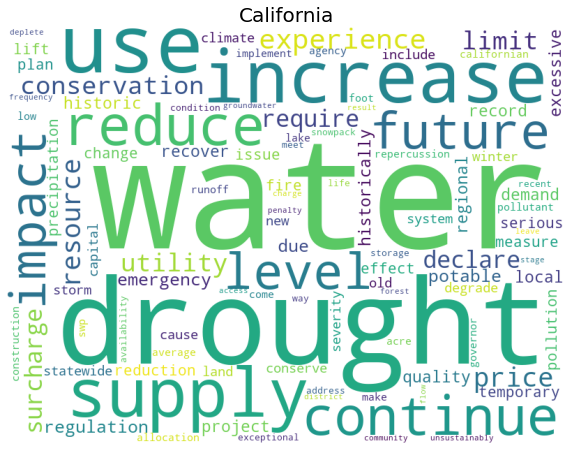

In [34]:
## Creating a wordcloud using top ranked 100 words California
plt.subplots(figsize=(10,10))
wc_cali = WordCloud(background_color = 'white',
              width=800,height=600,
              max_words=2000).fit_words(top100words_cali[:100])
plt.imshow(wc_cali)
plt.axis("off")
plt.title('California',fontsize=20)

plt.show()

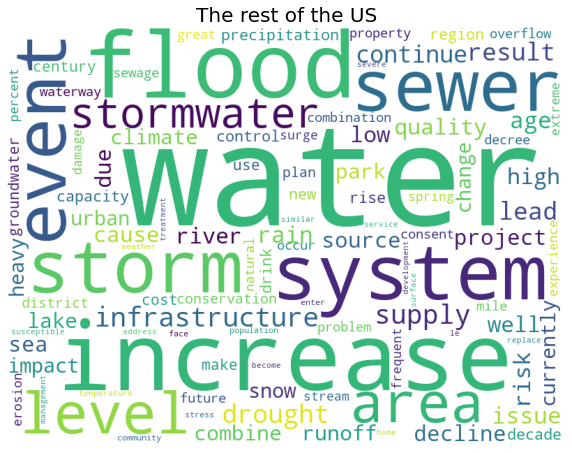

In [35]:
## Creating a wordcloud using top ranked 100 words for the rest of the US
plt.subplots(figsize=(10,10))
wc_us = WordCloud(background_color = 'white',
              width=800,height=600,
              max_words=2000).fit_words(top100words_us[:100])
plt.imshow(wc_us)
plt.title('The rest of the US', fontsize=20)
plt.axis("off")
#plt.savefig('top100words.pdf')
plt.show()

Our findings: 
- Both California and the rest of the US use the word ***water*** and ***increase*** drawing attention to the increase in risk to water supply. 
- California seems to have more problems with drought and supply with words like ***supply***, ***amount***, ***resources***, ***limit*** and price (e.g., ***price***, ***surcharge***, ***excessive***). Additionally, they talk about the future in terms of conservation (e.g., ***project***, ***future***, ***conserve***, ***conservation***) and the impact of drought with adjectives such as ***serious***, ***excessive***, ***record***. 
- The rest of the US appears to have more problems related to the infrastructure with words such as ***sewer***, ***system***, ***infrastructure***, and severe weather (e.g., ***storm***, ***rain***, ***precipitation and flooding***). They also mention drought but less often than California. 

This concludes the project on water scarcity. Thanks for reading! 